<a href="https://colab.research.google.com/github/Siavashghaffari/MASK_RCNN/blob/main/Copy_of_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Mask R-CNN instance segmentation training Demo**

Jupyter notebook providing steps to train a **Matterport Mask R-CNN** model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com/) using [Matterport framework](https://github.com/matterport/Mask_RCNN) with TensorFlow backend.

This notebook shows how to train Mask R-CNN on your own dataset. This is a demo version which allows you to train your detector for 1 class.
- Requirements are only dataset images and an annotations file.

## **1. Installation**

Update to Tensorflow 2.5

In [ ]:
# Update CUDA for TF 2.5
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
# Check if package has been installed
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
# Upgrade Tensorflow
!pip install --upgrade tensorflow==2.5.0

--2023-01-16 15:42:27--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430460776 (411M) [application/x-deb]
Saving to: ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’

libcudnn8_8.1.0.77- 100%[===================>] 410.52M   203MB/s    in 2.0s    

2023-01-16 15:42:29 (203 MB/s) - ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb’ saved [430460776/430460776]

dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 8.1.0.77-1+cuda11.2
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.1.1.33-1+cuda11.2) ...
Setting up libcudnn8 (8.1.0.77-1+c

Check if the GPU is enabled

In [ ]:
!nvidia-smi

Mon Jan 16 15:45:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install MASK RCNN_package from the github 

In [ ]:
! git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 24.71 MiB/s, done.
Resolving deltas: 100% (558/558), done.


Navigate to the Mask RCNN directory

In [ ]:
%cd /content/Mask_RCNN

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install
     

/content/Mask_RCNN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 12.3 MB/s eta 0:00:00
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  warnings.warn(
/usr/local/lib/

import required libraries

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import shutil
import zipfile
%matplotlib inline

Download pretrained model. Pretrained weights options are COCO, ImageNet or a model trained before

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/maskrcnn_colab")
print("VERS 0.4 - updated 04/08/2022")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn_demo.config import Config
from mrcnn_demo import utils
import mrcnn_demo.model as modellib
from mrcnn_demo import visualize
from mrcnn_demo.model import log
from PIL import Image, ImageDraw

import warnings
warnings.filterwarnings('ignore')


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

VERS 0.4 - updated 04/08/2022


Configuration for training on the toy shapes dataset.
Derives from the base Config class and overrides values specific to the toy shapes dataset

In [ ]:
class CustomConfig(Config):
    def __init__(self, num_classes):

        if num_classes > 1:
            raise ValueError("{} classes were found. This is only a DEMO version for evaluation purposes, and it only supports 1 class. Get the PRO version to"
                  " continue the training: https://pysource.com/mask-rcnn-training-pro/ ".format(num_classes))

        classes_number = num_classes
        super().__init__()
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes
    NUM_CLASSES = 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

    ETF_C = 2

    DETECTION_MIN_CONFIDENCE = 0.9


#### NOTEBOOK PREFERENCES

In [ ]:
"""
NOTEBOOK PREFERENCES
"""
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset

In [ ]:
class CustomDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_custom(self, annotation_json, images_dir, dataset_type="train"):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """

        # Load json from file
        print("Annotation json path: ", annotation_json)
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()


        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']

            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}

        # Split the dataset, if train, get 90%, else 10%
        len_images = len(coco_json['images'])
        if dataset_type == "train":
            img_range = [int(len_images / 9), len_images]
        else:
            img_range = [0, int(len_images / 9)]

        for i in range(img_range[0], img_range[1]):
            image = coco_json['images'][i]
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        #print("Class_ids, ", class_ids)
        return mask, class_ids

    def count_classes(self):
        class_ids = set()
        for image_id in self.image_ids:
            image_info = self.image_info[image_id]
            annotations = image_info['annotations']

            for annotation in annotations:
                class_id = annotation['category_id']
                class_ids.add(class_id)

        class_number = len(class_ids)
        return class_number


Train the head branches

In [ ]:
def load_training_model(config):
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)

    # Which weights to start with?
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        print(COCO_MODEL_PATH)
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)

    return model

def display_image_samples(dataset_train):
    # Load and display random samples
    image_ids = np.random.choice(dataset_train.image_ids, 4)

    for image_id in image_ids:
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)
        visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

def load_image_dataset(annotation_path, dataset_path, dataset_type):
    dataset_train = CustomDataset()
    dataset_train.load_custom(annotation_path, dataset_path, dataset_type)
    dataset_train.prepare()
    return dataset_train

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
def train_head(model, dataset_train, dataset_val, config):
    model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=5,
            layers='heads')



Inference helper functions

In [ ]:
""" DETECTION TEST YOUR MODEL """

class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

def extract_images(my_zip, output_dir):
    # Make directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with zipfile.ZipFile(my_zip) as zip_file:
        count = 0
        for member in zip_file.namelist():
            filename = os.path.basename(member)
            # skip directories
            if not filename:
                continue
            count += 1
            # copy file (taken from zipfile's extract)
            source = zip_file.open(member)
            target = open(os.path.join(output_dir, filename), "wb")
            with source, target:
                shutil.copyfileobj(source, target)
        print("Extracted: {} images".format(count))


def load_test_model(num_classes):
    inference_config = InferenceConfig(num_classes)

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference",
                              config=inference_config,
                              model_dir=MODEL_DIR)

    # Get path to saved weights
    # Either set a specific path or find last trained weights
    # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
    model_path = model.find_last()

    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    return model, inference_config

def load_inference_model(num_classes, model_path):
    inference_config = InferenceConfig(num_classes)

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference",
                              config=inference_config,
                              model_dir=model_path)

    # Get path to saved weights
    # Either set a specific path or find last trained weights
    # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
    #model_path = model.find_last()

    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    return model, inference_config

def test_random_image(test_model, dataset_val, inference_config):
    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    log("original_image", original_image)
    # log("image_meta", image_meta)
    # log("gt_class_id", gt_class_id)
    # log("gt_bbox", gt_bbox)
    # log("gt_mask", gt_mask)

    # Model result
    print("Trained model result")
    results = test_model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False)

    print("Annotation")
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset_val.class_names, figsize=(8, 8))


## **2. Image Dataset**

Load your annotated dataset
Your dataset should contain:

1- A zip file containing jpg image files of training and test data (zip the folder of conting all the images)

2- Annotations file of all images in *.json format Upload both of them in the /content easily using drag and drop

Input the correct name and location of those files below here


In [ ]:
# Extract Images
images_path = "dataset.zip"
annotations_path = "annotations.json"

extract_images(os.path.join("/content/",images_path), "/content/dataset")

Extracted: 43 images


Randomly divide images into train and validation sets

In [ ]:
dataset_train = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "train")
dataset_val = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "val")
class_number = dataset_train.count_classes()
print('Train: %d' % len(dataset_train.image_ids))
print('Validation: %d' % len(dataset_val.image_ids))
print("Classes: {}".format(class_number))

Annotation json path:  /content/annotations.json
Annotation json path:  /content/annotations.json
Train: 39
Validation: 4
Classes: 1


Display training image samples

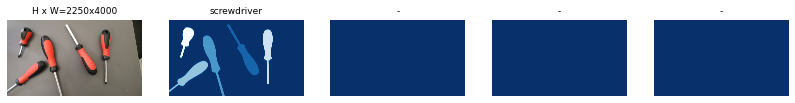

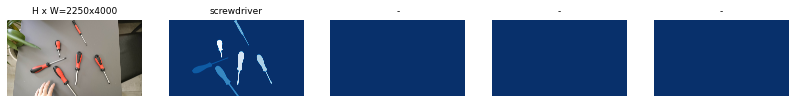

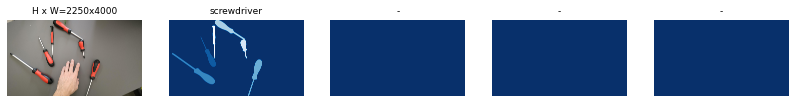

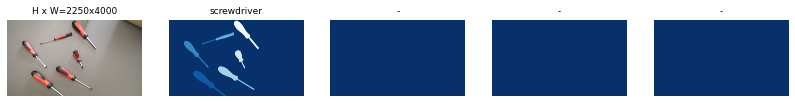

In [ ]:
# Load image samples
display_image_samples(dataset_train)

##**3. Training**

Train Mask RCNN on your custom Dataset.

Training configuration

In [ ]:
# Load Configuration
config = CustomConfig(class_number)
# config.display()
model = load_training_model(config)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/content/maskrcnn_colab/mask_rcnn_coco.h5


Training process, each epoch approximately takes around 30 minutes, 5 epoch in total. You may stop it after one epoch is fully completed but the result is not accurate enough

In [ ]:
# Start Training
# This operation might take a long time.
train_head(model, dataset_train, dataset_train, config)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/maskrcnn_colab/logs/object20230116T1554/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_mask_deconv  

## **4. Detection (test your model on a random image)**

Load test model from what we trained. The model is saved in the log folder in the HDF format

In [ ]:
# Load Test Model
# The latest trained model will be loaded
test_model, inference_config = load_test_model(class_number)

Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/maskrcnn_colab/logs/object20230116T1554/mask_rcnn_object_0005.h5
Re-starting from epoch 5


Display the result of the trained model on a random image from validation set

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
Trained model result
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Annotation


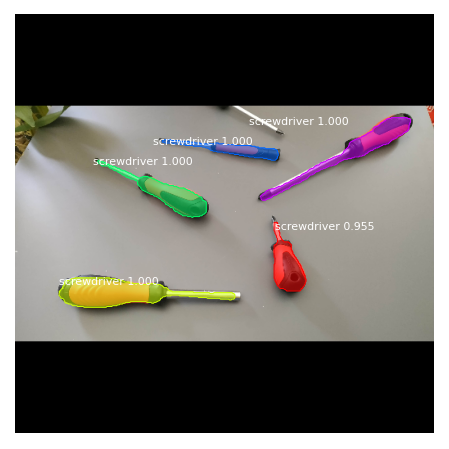

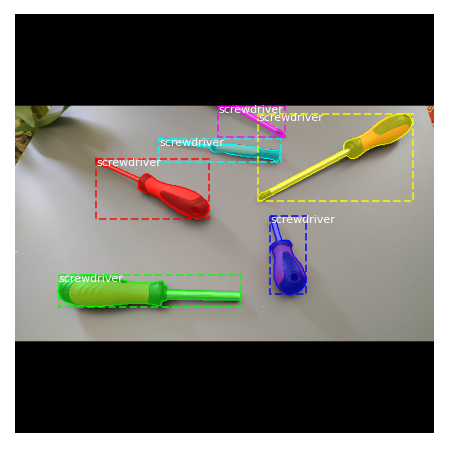

In [ ]:
# Test on a random image
test_random_image(test_model, dataset_val, inference_config)